## -v

In [ ]:
!nvidia-smi

Sun May 23 14:59:54 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!nvcc --version
!gcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Wed_Jul_22_19:09:09_PDT_2020
Cuda compilation tools, release 11.0, V11.0.221
Build cuda_11.0_bu.TC445_37.28845127_0
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



## installations

In [ ]:
!pip install torch==1.7.1+cu110 torchvision==0.8.2+cu110 -f https://download.pytorch.org/whl/torch_stable.html

In [ ]:
!pip install mmcv-full
!pip install mmdet

     |████████████████████████████████| 296kB 14.0MB/s 
     |████████████████████████████████| 194kB 22.0MB/s 
  Created wheel for mmcv-full: filename=mmcv_full-1.3.4-cp37-cp37m-linux_x86_64.whl size=26332799 sha256=e1ff527e7114e5844ba024b61f42c205119df0d31a08781e5bd5a5f279f0930e
  Stored in directory: /root/.cache/pip/wheels/d4/39/64/573a0673de0ee0c6b699dddfae8232d485ea8da749caa198fd
Successfully built mmcv-full
     |████████████████████████████████| 593kB 13.7MB/s 
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp37-none-any.whl size=15356 sha256=e33967f5dd21763d0814d92bca1524d223422e9a14531a9b4d8a52dd6d5444e1
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built terminaltables


## files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import files

%rm faster_rcnn_r50_fpn_1x_coco_stable_latest.py
%rm faster_rcnn_r50_fpn_1x_coco_stable.py
%rm faster_rcnn_r50_fpn_1x_coco.py
%rm level.py
files = files.upload()

rm: cannot remove 'faster_rcnn_r50_fpn_1x_coco_stable_latest.py': No such file or directory
rm: cannot remove 'faster_rcnn_r50_fpn_1x_coco_stable.py': No such file or directory
rm: cannot remove 'faster_rcnn_r50_fpn_1x_coco.py': No such file or directory
rm: cannot remove 'level.py': No such file or directory


Saving faster_rcnn_r50_fpn_1x_coco.py to faster_rcnn_r50_fpn_1x_coco.py
Saving level.py to level.py


## cfg

In [ ]:
def get_classes_from_dataset(dataset_path):
  from json import load

  with open(dataset_path, 'r+') as file:
    data = load(file)
  file.close()
  return [c['name'] for c in data['categories']]

def merge_classes(first_list, second_list):
  first_list.extend(second_list)
  return list(set(first_list))

In [ ]:
import mmcv
from mmdet.apis import set_random_seed


cfg = mmcv.Config.fromfile(list(files)[0])

# classes = ('ground', 'circuit breaker', 'withdrawable circuit breaker', 'single-phase circuit breaker', 'three-phase circuit breaker',
#  'differential circuit breaker 220V', 'differential circuit breaker 380V', 'RCD 220V', 'direct connection counter', 'withdrawable circuit breaker with motor drive',
#  'fuse switch disconnector', 'instrument current transformer', 'reactive power compensation device', 'Inductor', 'four-phase circuit breaker',
#  'motorized switch', 'three-phase switch', 'switch', 'voltage monitoring relay', 'surge protection device', 'fuse', 'motorized single-phase circuit breaker',
#  'motorized three-phase circuit breaker', 'transformer', 'motorizwd circuit breaker', 'capasitor ', 'lamp', 'photoresistor', 'two-phase circuit breaker')

classes = ('v', 'h')


cfg.dataset_type = 'CocoDataset'

cfg.data.train.ann_file = f'/content/drive/MyDrive/text_detection/datasets/18-05-train.json'
cfg.data.train.data_root = f'/content/drive/MyDrive/datasets/scheme_copy'
cfg.data.train.img_prefix = f'' 

cfg.data.val.ann_file = f'/content/drive/MyDrive/text_detection/datasets/18-05-test.json'
cfg.data.val.data_root = f'/content/drive/MyDrive/datasets/scheme_copy'
cfg.data.val.img_prefix = f''

# classes = merge_classes(get_classes_from_dataset(cfg.data.train.ann_file), get_classes_from_dataset(cfg.data.train.ann_file))
cfg.model.roi_head.bbox_head.num_classes = len(classes)
cfg.data.val.classes = classes
cfg.data.train.classes = classes

cfg.log_config.interval = 95
cfg.evaluation.interval = 50
cfg.checkpoint_config.interval = 50

cfg.lr_config.policy = 'step'
cfg.work_dir = '/content/drive/MyDrive/logs/logs-20-05'

cfg.resume_from = '/content/drive/MyDrive/logs/logs-20-05/latest.pth'

cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

## dataset

In [ ]:
from mmdet.datasets import build_dataset
datasets = [build_dataset(cfg.data.train)]

loading annotations into memory...
Done (t=0.75s)
creating index...
index created!


## train

In [ ]:
from mmdet.apis import train_detector
from mmdet.models import build_detector
import os.path as osp


model = build_detector(cfg.model, test_cfg=cfg.get('test_cfg'), train_cfg=cfg.get('train_cfg'))
model.init_weights()

model.CLASSES = datasets[0].CLASSES

mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_detector(model, datasets, cfg, distributed=False, validate=True)

2021-05-23 15:15:30,843 - mmcv - INFO - load model from: open-mmlab://detectron2/resnet50_caffe
2021-05-23 15:15:30,844 - mmcv - INFO - Use load_from_openmmlab loader
Downloading: "https://download.openmmlab.com/pretrain/third_party/resnet50_msra-5891d200.pth" to /root/.cache/torch/hub/checkpoints/resnet50_msra-5891d200.pth


2021-05-23 15:15:43,009 - mmcv - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: conv1.bias



/usr/local/lib/python3.7/dist-packages/mmcv/cnn/utils/weight_init.py:100: UserWarning: init_cfg without layer key, if you do not define override key either, this init_cfg will do nothing
  'init_cfg without layer key, if you do not define override'


loading annotations into memory...


2021-05-23 15:15:50,052 - mmdet - INFO - load checkpoint from /content/drive/MyDrive/logs/logs-20-05/latest.pth
2021-05-23 15:15:50,054 - mmdet - INFO - Use load_from_local loader


Done (t=0.35s)
creating index...
index created!


2021-05-23 15:15:58,454 - mmdet - INFO - resumed epoch 700, iter 67200
2021-05-23 15:15:58,457 - mmdet - INFO - Start running, host: root@aed14c88661d, work_dir: /content/drive/MyDrive/logs/logs-20-05
2021-05-23 15:15:58,461 - mmdet - INFO - workflow: [('train', 1)], max: 1000 epochs
2021-05-23 15:17:14,243 - mmdet - INFO - Epoch [701][95/96]	lr: 5.000e-07, eta: 6:18:20, time: 0.791, data_time: 0.355, memory: 11287, loss_rpn_cls: 0.0004, loss_rpn_bbox: 0.0031, loss_cls: 0.0070, acc: 99.7060, loss_bbox: 0.0184, loss: 0.0290
2021-05-23 15:18:11,578 - mmdet - INFO - Epoch [702][95/96]	lr: 5.000e-07, eta: 5:27:05, time: 0.588, data_time: 0.058, memory: 11287, loss_rpn_cls: 0.0003, loss_rpn_bbox: 0.0028, loss_cls: 0.0067, acc: 99.7286, loss_bbox: 0.0173, loss: 0.0270
2021-05-23 15:19:07,279 - mmdet - INFO - Epoch [703][95/96]	lr: 5.000e-07, eta: 5:08:13, time: 0.580, data_time: 0.050, memory: 11287, loss_rpn_cls: 0.0002, loss_rpn_bbox: 0.0026, loss_cls: 0.0067, acc: 99.7163, loss_bbox: 0.01

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 48/48, 2.8 task/s, elapsed: 17s, ETA:     0s

2021-05-23 16:02:48,655 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2021-05-23 16:02:49,491 - mmdet - INFO - Saving checkpoint at 750 epochs


DONE (t=0.79s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.309
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.417
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.358
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.091
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.326
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.313
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.333
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.333
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.333
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.105
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.353
 Average Recall     (AR) @[ IoU=0.50:0.95 | a

2021-05-23 16:02:51,540 - mmdet - INFO - Epoch(val) [750][96]	bbox_mAP: 0.3090, bbox_mAP_50: 0.4170, bbox_mAP_75: 0.3580, bbox_mAP_s: 0.0910, bbox_mAP_m: 0.3260, bbox_mAP_l: 0.3130, bbox_mAP_copypaste: 0.309 0.417 0.358 0.091 0.326 0.313
2021-05-23 16:03:47,846 - mmdet - INFO - Epoch [751][95/96]	lr: 5.000e-07, eta: 3:49:23, time: 0.591, data_time: 0.057, memory: 11287, loss_rpn_cls: 0.0002, loss_rpn_bbox: 0.0021, loss_cls: 0.0060, acc: 99.7677, loss_bbox: 0.0146, loss: 0.0230
2021-05-23 16:04:43,561 - mmdet - INFO - Epoch [752][95/96]	lr: 5.000e-07, eta: 3:48:27, time: 0.580, data_time: 0.052, memory: 11287, loss_rpn_cls: 0.0002, loss_rpn_bbox: 0.0021, loss_cls: 0.0057, acc: 99.7852, loss_bbox: 0.0145, loss: 0.0226
2021-05-23 16:05:39,694 - mmdet - INFO - Epoch [753][95/96]	lr: 5.000e-07, eta: 3:47:33, time: 0.585, data_time: 0.061, memory: 11287, loss_rpn_cls: 0.0003, loss_rpn_bbox: 0.0021, loss_cls: 0.0060, acc: 99.7636, loss_bbox: 0.0142, loss: 0.0227
2021-05-23 16:06:35,362 - mmde

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 48/48, 4.6 task/s, elapsed: 11s, ETA:     0s

2021-05-23 16:49:10,545 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2021-05-23 16:49:11,390 - mmdet - INFO - Saving checkpoint at 800 epochs


DONE (t=0.80s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.309
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.417
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.354
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.091
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.325
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.309
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.333
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.333
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.333
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.105
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.353
 Average Recall     (AR) @[ IoU=0.50:0.95 | a

2021-05-23 16:49:13,330 - mmdet - INFO - Epoch(val) [800][96]	bbox_mAP: 0.3090, bbox_mAP_50: 0.4170, bbox_mAP_75: 0.3540, bbox_mAP_s: 0.0910, bbox_mAP_m: 0.3250, bbox_mAP_l: 0.3090, bbox_mAP_copypaste: 0.309 0.417 0.354 0.091 0.325 0.309
2021-05-23 16:50:08,447 - mmdet - INFO - Epoch [801][95/96]	lr: 5.000e-07, eta: 3:02:29, time: 0.579, data_time: 0.056, memory: 11287, loss_rpn_cls: 0.0002, loss_rpn_bbox: 0.0021, loss_cls: 0.0058, acc: 99.7687, loss_bbox: 0.0140, loss: 0.0220
2021-05-23 16:51:03,452 - mmdet - INFO - Epoch [802][95/96]	lr: 5.000e-07, eta: 3:01:32, time: 0.573, data_time: 0.053, memory: 11287, loss_rpn_cls: 0.0002, loss_rpn_bbox: 0.0021, loss_cls: 0.0057, acc: 99.7810, loss_bbox: 0.0144, loss: 0.0224
2021-05-23 16:51:58,794 - mmdet - INFO - Epoch [803][95/96]	lr: 5.000e-07, eta: 3:00:37, time: 0.577, data_time: 0.056, memory: 11287, loss_rpn_cls: 0.0002, loss_rpn_bbox: 0.0021, loss_cls: 0.0056, acc: 99.7862, loss_bbox: 0.0142, loss: 0.0220
2021-05-23 16:52:54,499 - mmde

## check

In [ ]:
from mmdet.apis import init_detector, inference_detector
from mmdet.apis import show_result_pyplot
import os

checkpoint_file = '/content/drive/MyDrive/logs/logs-18-04/latest.pth'

model = init_detector(cfg, checkpoint_file, device='cuda:0')

In [ ]:
img_path = 'test-1.jpeg'
img = mmcv.imread(os.path.join('/content/drive/MyDrive/datasets/examples/', img_path))
result = inference_detector(model, img)
model.show_result(img, result, out_file=os.path.join('/content/drive/MyDrive/datasets/examples/test_results/test-17', img_path))

## on-site check

In [ ]:
from mmdet.apis import init_detector, inference_detector
from mmdet.apis import show_result_pyplot


checkpoint_file = '/content/drive/MyDrive/logs/logs-20-05/latest.pth'

model = init_detector(cfg, checkpoint_file, device='cuda:0')
model.cfg = cfg

Use load_from_local loader


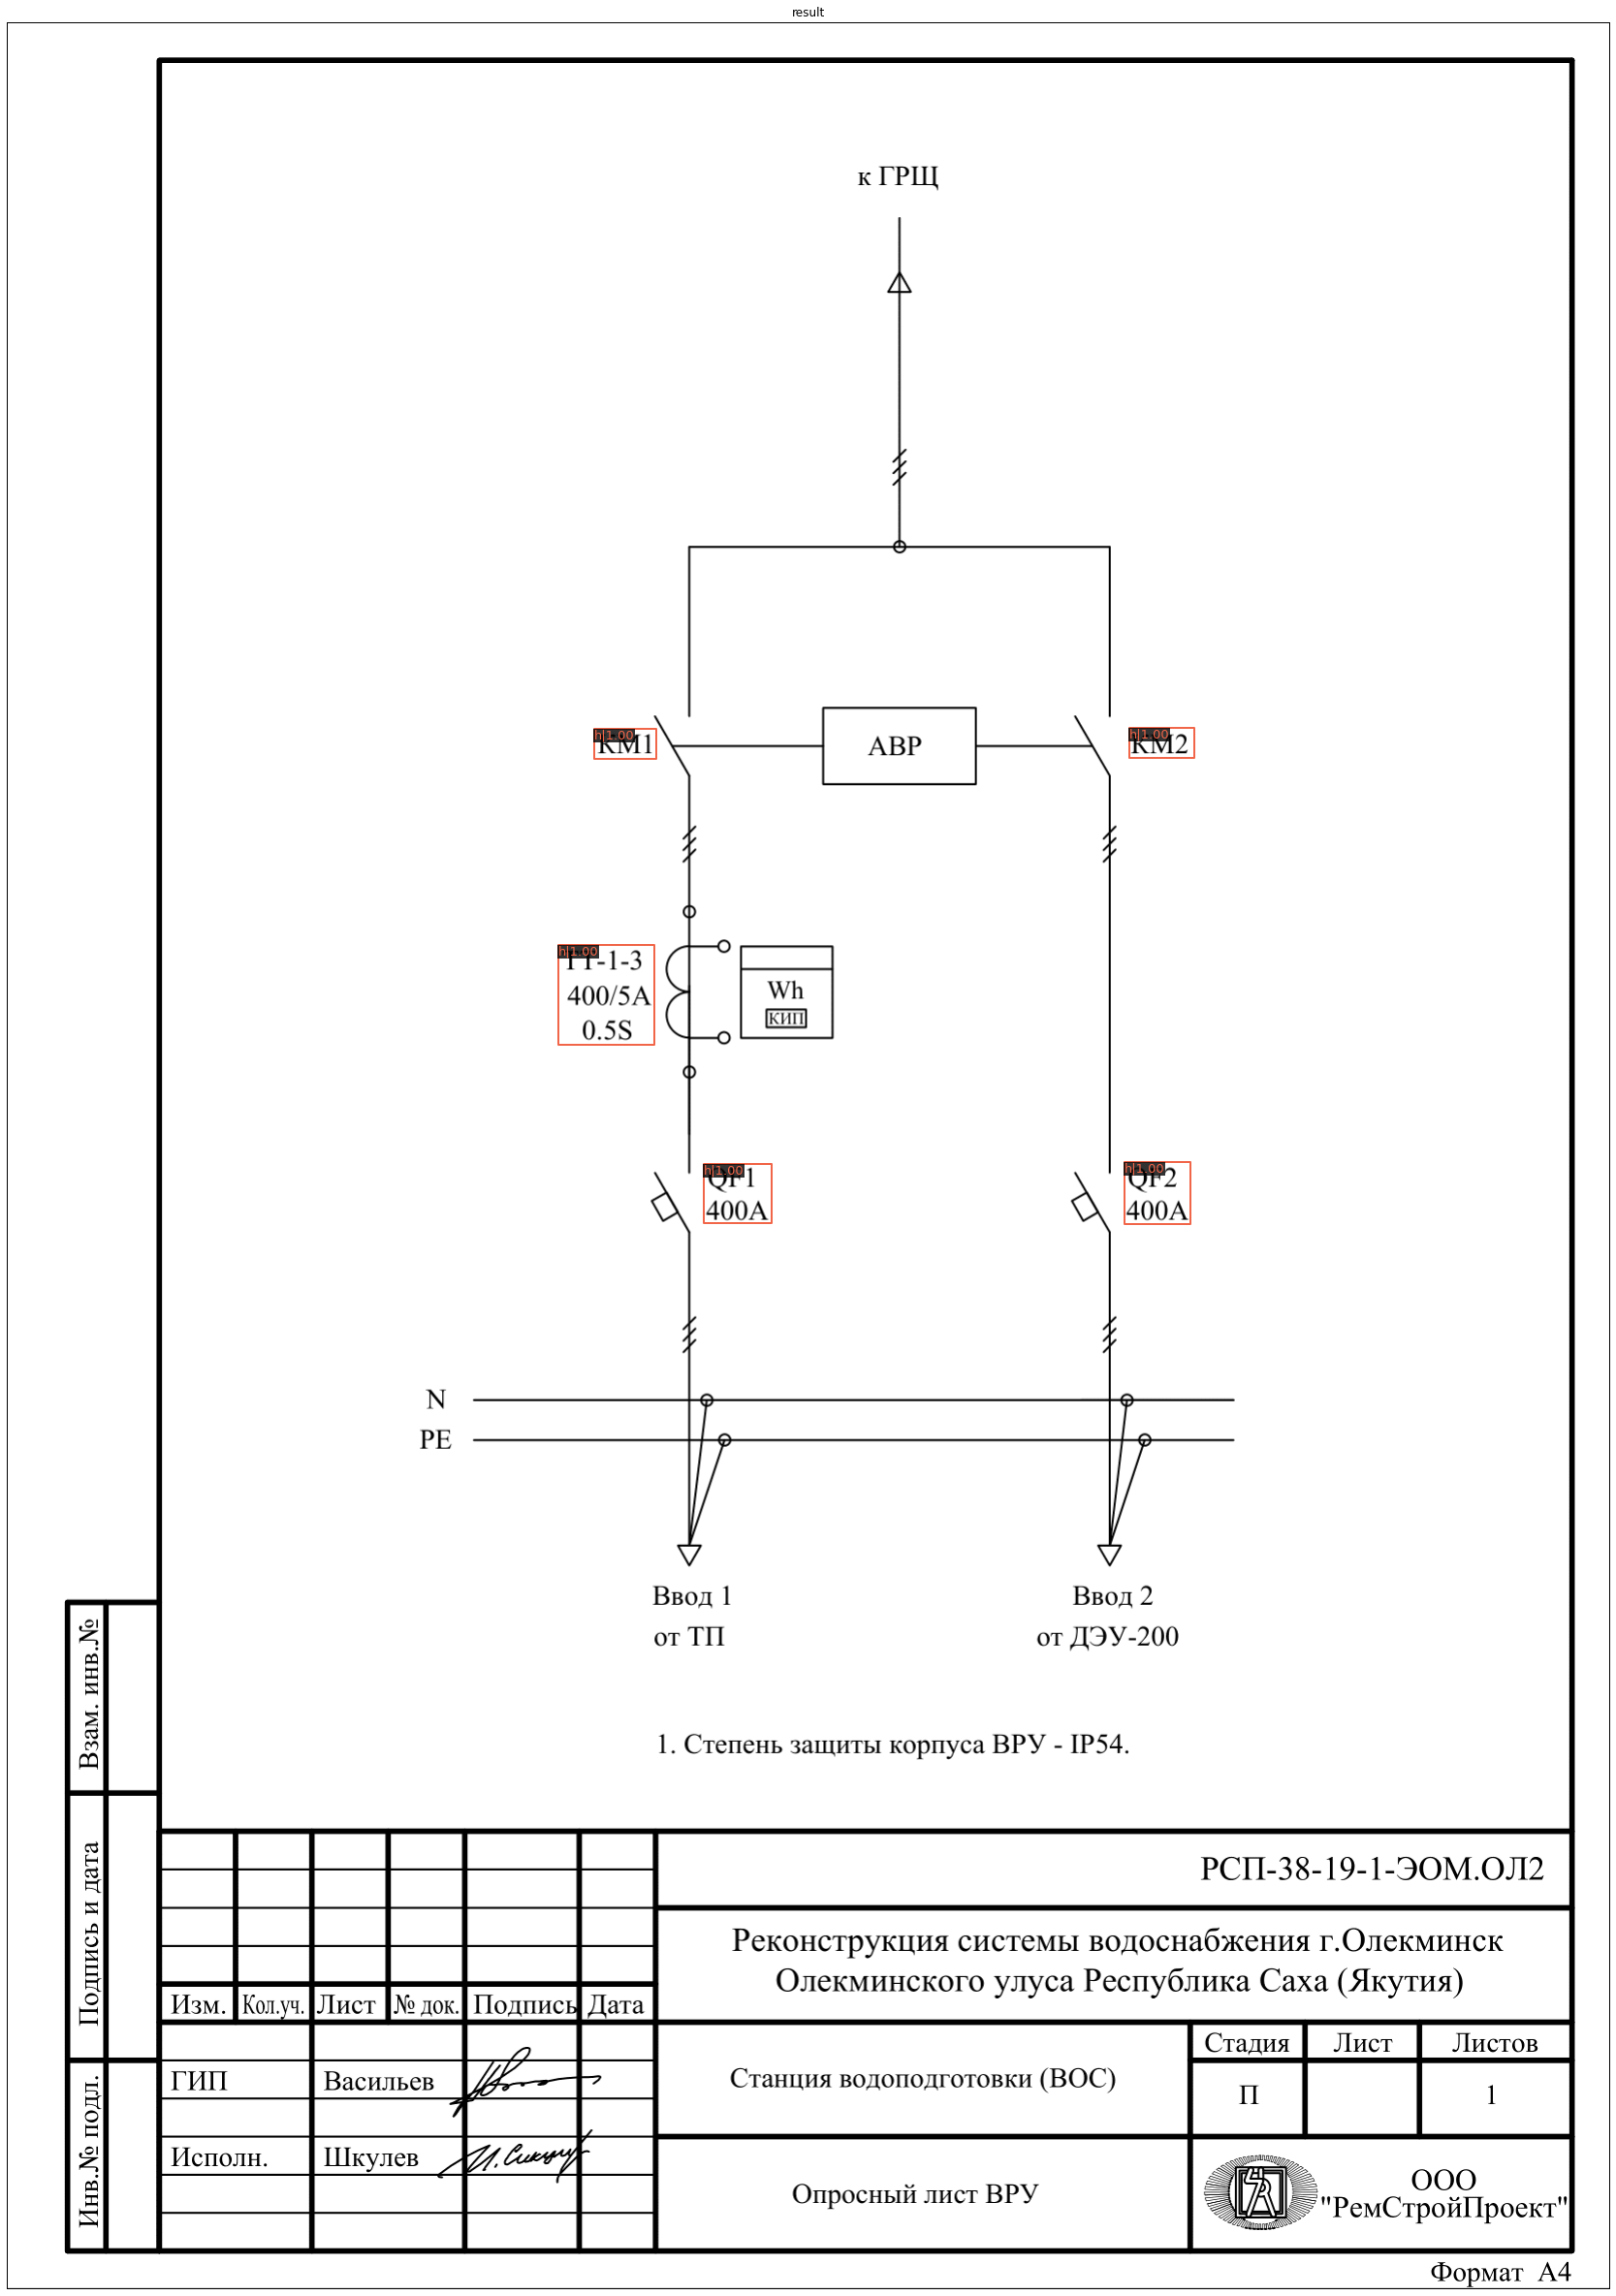

In [ ]:
img_name = 'scheme_019.png'
img = mmcv.imread(os.path.join('/content/drive/MyDrive/datasets/scheme_copy/', img_name))
result = inference_detector(model, img)
# model.show_result(img, result, out_file=os.path.join('/content/drive/MyDrive/datasets/examples/test_results/800', img_path))
show_result_pyplot(model, img, result)

In [ ]:
import json

with open(f'/content/drive/MyDrive/datasets/coco/labels_test.json', 'r') as file:
    data = json.load(file)
file.close()
names = sorted([img['file_name'] for img in data['images']])

for img_name in names:
  img = mmcv.imread(os.path.join('/content/drive/MyDrive/datasets/scheme_copy/', img_name))
  result = inference_detector(model, img)
  model.show_result(img, result, out_file=os.path.join('/content/drive/MyDrive/text_detection/test_results_700_full', img_name))